<h2 align=center>Generate Synthetic Images with DCGANs in Keras</h2>

## Import Libraries




In [9]:
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython import display
!pip install visualkeras
import visualkeras
print('Tensorflow version:', tf.__version__)

Tensorflow version: 2.15.0


## Load the Data

In [4]:
(X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train = X_train.astype(np.float32) / 255.0
X_test = X_test.astype(np.float32) / 255.0

4422102/4422102 [==============================] - 0s 0us/step


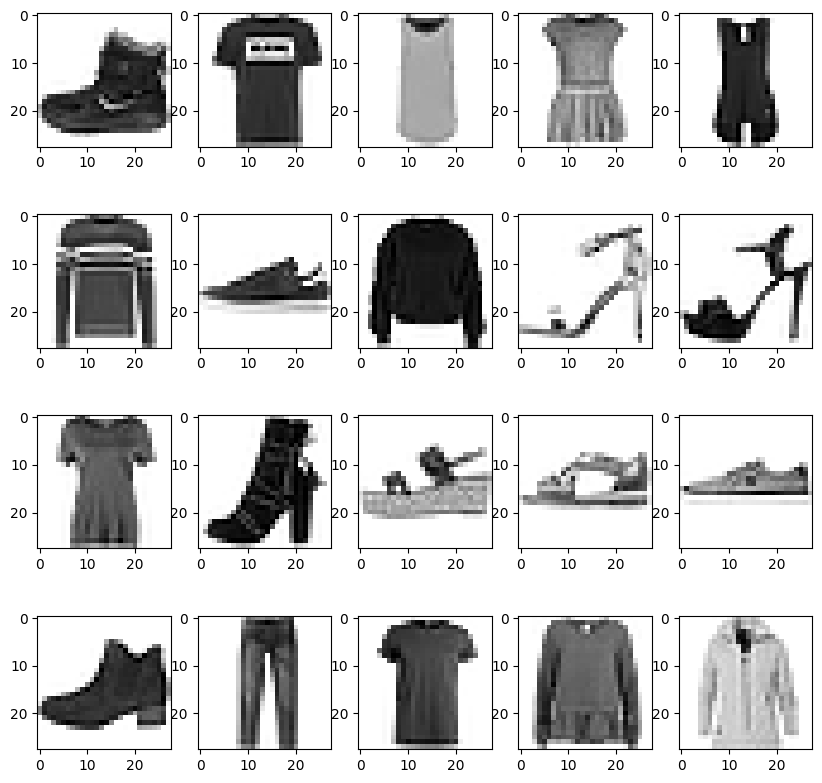

In [5]:
plt.figure(figsize=(10,10))
for i in range(20):
  plt.subplot(4,5,i+1)
  plt.imshow(X_train[i], cmap = plt.cm.binary)
plt.show()

## Create Batches of Training Data

In [6]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000) # loading data into tensorflow dataset
dataset = dataset.batch(batch_size, drop_remainder = True).prefetch(buffer_size=1) # creating batches of dataset and using prfetch to fetch one batch in advance

## Build the Generator Network for DCGAN

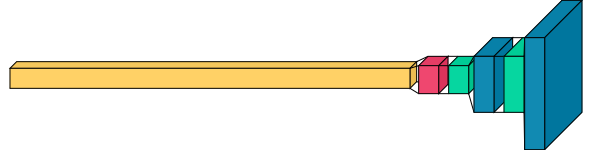

In [10]:
num_features = 100 # size of input random vector noise
generator = keras.models.Sequential([
    keras.layers.Dense(7*7*128, input_shape=[num_features]), # first layer cosisting of 7x7x128 = 12544 neurons
    keras.layers.Reshape([7,7,128]), # reshape the output of first layer from (12544,) to (7,7,128)
    keras.layers.BatchNormalization(), # normalize the activation results of first layer of neurons
    keras.layers.Conv2DTranspose(64, (5,5), (2,2), padding='same', activation='selu'), # upscaling
    keras.layers.BatchNormalization(), # normalize the activation results of second layer
    keras.layers.Conv2DTranspose(1, (5,5), (2,2), padding='same', activation='tanh') # final layer, giving output a single channel image of dimension (28,28,1)
])
visualkeras.layered_view(generator)

## Build the Discriminator Network for DCGAN

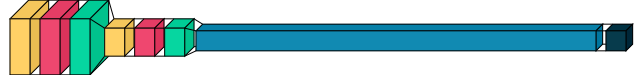

In [11]:
discriminator = keras.models.Sequential([
    keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),
    keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),
    keras.layers.Flatten(), # flattening the result of CNN to perform classification via dense layer
    keras.layers.Dense(1, activation='sigmoid') # performing binary classification
])
visualkeras.layered_view(discriminator)

## Compile the Deep Convolutional Generative Adversarial Network (DCGAN)

In [ ]:
discriminator.compile(loss='binary_crossentropy', optimizer='rmsprop')
discriminator.trainable = False # fixing parameters of discriminator, so that only generator will be trained in combined network
gan = keras.models.Sequential([generator, discriminator])
gan.compile(loss='binary_crossentropy', optimizer='rmsprop')

## Define Training Procedure

In [ ]:
seed = tf.random.normal(shape=[batch_size, 100])

In [ ]:
def train_dcgan(gan, dataset, batch_size, num_features, epochs=5):
  generator, discriminator = gan.layers

  for epoch in tqdm(range(epochs)):
    print(f"EPOCH : {epoch+1}")

    for X_batch in dataset:

      noise = tf.random.normal(shape=[batch_size, num_features]) # noise feature vector of size (32,100)
      generated_images = generator(noise) # passing noise through generator to form a image of size (28,28,1)
      X_fake_and_real = tf.concat([generated_images, X_batch], axis = 0) # conctenation of fake and real images [[fake_image],[real_image]]
      y1 = tf.constant([[0.]]*batch_size + [[1.]]*batch_size) # desired output for discriminator is that it will detect all fakes and reals correctly
      discriminator.trainable = True # to train params of discriminator neural network
      discriminator.train_on_batch(X_fake_and_real, y1) # training discriminator over real and fake images in batch
      y2 = tf.constant([[1.]]*batch_size) # desired output for generator is that fake images are characterized as real by discriminator
      discriminator.trainable = False # stop training of params of discriminator while training the generator
      gan.train_on_batch(noise, y2) # training generator by inputing noise batch and expecting it to fool discriminator by creating a real like image
    display.clear_output(wait = True) # removing previous plots
    generate_and_save_images(generator, epoch + 1, seed) # showing plot after current epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator, epochs, seed)

In [ ]:
## Source https://www.tensorflow.org/tutorials/generative/dcgan#create_a_gif
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(10,10))

    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='binary')
        plt.axis('off')
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

## Train DCGAN

In [ ]:
x_train_dcgan = X_train.reshape(-1,28,28,1)*2.-1

In [ ]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(x_train_dcgan).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder = True).prefetch(1)

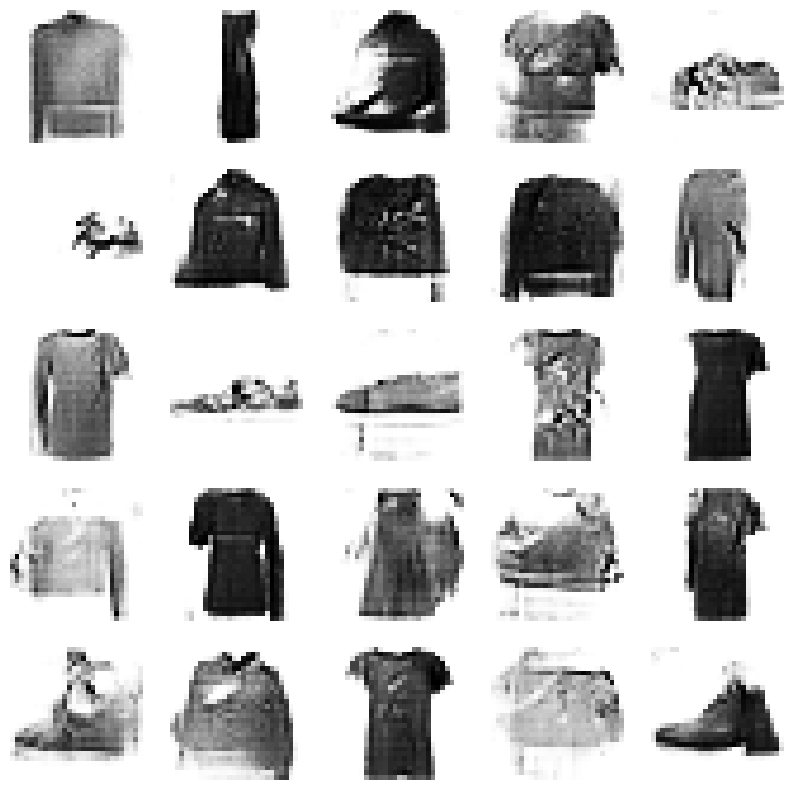

CPU times: user 10min 8s, sys: 23.2 s, total: 10min 31s
Wall time: 10min 51s


In [ ]:
%%time
train_dcgan(gan, dataset, batch_size, num_features, epochs = 10)

## Generate Synthetic Images with DCGAN

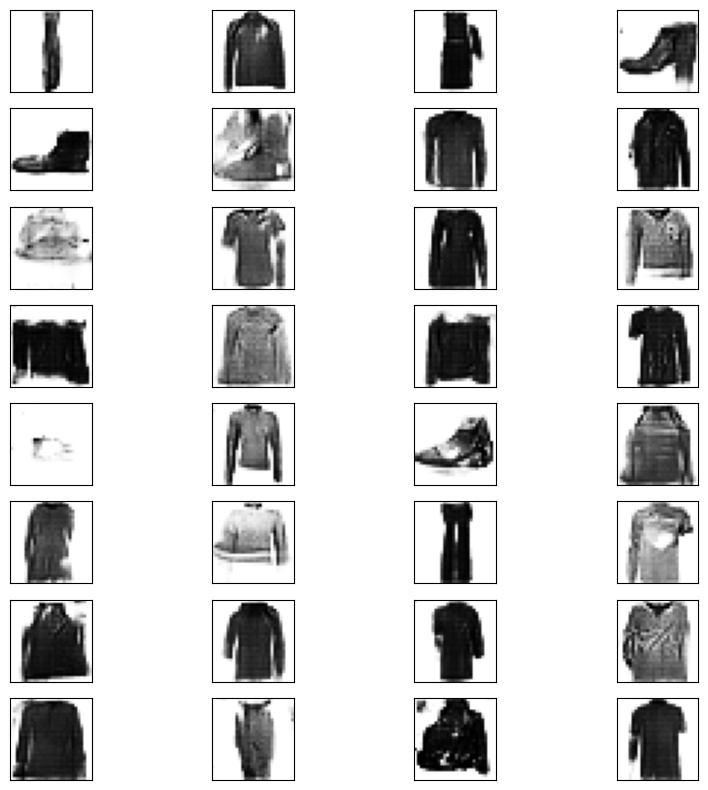

In [ ]:
noise = tf.random.normal(shape=[batch_size, num_features]) # creating a random vector to input into the generator
generated_images = generator(noise) # getting image from generator by giving random normal noise as input
generated_images_arr = generated_images.numpy()
plt.figure(figsize=(10,10))
for i in range(32):
  curr_img = generated_images_arr[i].reshape(28,28,1)
  plt.subplot(8,4,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(curr_img, cmap =  'binary')

<ipython-input-62-5ac5c96471b6>:18: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
<ipython-input-62-5ac5c96471b6>:20: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


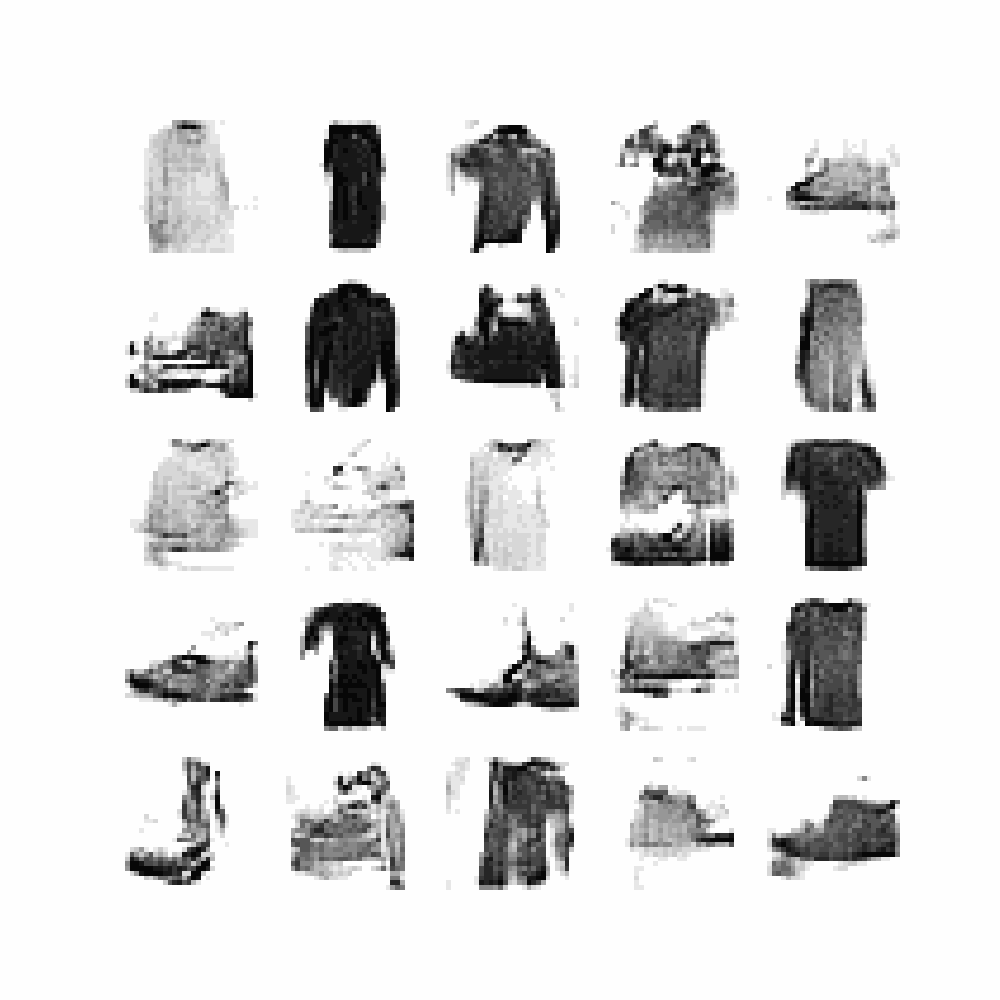

In [ ]:
## Source: https://www.tensorflow.org/tutorials/generative/dcgan#create_a_gif

import imageio
import glob

anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    last = -1
    for i,filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

import IPython
display.Image(filename=anim_file)